# Globals

In [336]:
from Models import TransformerBase, BufferEmbedding, BufferEncoding
from Models.util.qol import manage_params
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time as clock
from torch import Tensor
from torch.nn import Module
from torch.optim import lr_scheduler
from copy import deepcopy

%matplotlib inline

In [337]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32

# Data creation

In [338]:
MULTIPLIER = 0.01

In [339]:
def create_data(records: int, limits: tuple[int, int], seq_len: int, min_len: int | None = None,
                step: int | None = None, offset: int | None = None, embedded: bool = False,
                device: torch.device = 'cpu', dtype: torch.dtype = torch.float32):
    limit_range = limits[1] - limits[0]
    assert limit_range > (seq_len * 2 // step) + offset
    if min_len is None:
        min_len = seq_len
    assert min_len > 0
    if step is None:
        step = 1
    if offset is None:
        offset = 0

    inputs = torch.stack([
        torch.cat([
            torch.arange(start, start + seq_len - padding, step, device=device, dtype=torch.float64),
            torch.full((padding,), -1, device=device, dtype=torch.float64),
        ])
        for start, padding in zip(
            np.random.randint(limits[0], limits[0] + (limit_range // 1) - max(0, offset + seq_len), records),
            np.random.randint(0, seq_len - min_len + 1, records)
        )
    ])
    # print(inputs)
    try:
        outputs = torch.stack([
            torch.arange(start, start + seq_len, step, device=device, dtype=torch.float64)
            for start in [
                inp[inp != -1].min().cpu().item() + 1 + offset
                for inp in inputs
            ]
            # for start in (torch.max(inputs, -1,)[0] + 1)
        ])
    except Exception as e:
        print(inputs[:3, [0, 1, -2, -1]])
        raise e
    # print(outputs)

    cdtype = torch.int64 if dtype == torch.float64 else torch.int64
    return tuple([
        (t * (MULTIPLIER if not embedded else 1)).to(d)
        for t, d in zip([inputs, outputs], [dtype, dtype if not embedded else cdtype])
    ])

In [340]:
RECORDS = 1000
LIMITS = (0, 1000)
MAX_SEQ_LEN = 256
SEQ_LEN = 100
MIN_LEN = SEQ_LEN - 20
STEP = 1
OFFSET = 0
EMBEDDED = True

In [341]:
train_inp, train_out = create_data(RECORDS, LIMITS, SEQ_LEN, MIN_LEN, STEP, OFFSET, EMBEDDED, DEVICE, DTYPE)
eval_inp, eval_out = create_data(RECORDS // 1, LIMITS, SEQ_LEN, MIN_LEN, STEP, OFFSET, EMBEDDED, DEVICE, DTYPE)
train_inp.shape, train_out.shape, eval_inp.shape, eval_out.shape

(torch.Size([1000, 100]),
 torch.Size([1000, 100]),
 torch.Size([1000, 100]),
 torch.Size([1000, 100]))

In [342]:
train_inp.device, train_inp.dtype, eval_inp.device, eval_out.dtype

(device(type='cuda', index=0),
 torch.float32,
 device(type='cuda', index=0),
 torch.int64)

In [343]:
def print_tensor(tensor: Tensor, indices: list[int] | None = None):
    if not EMBEDDED:
        return torch.round(tensor[:, indices].to(torch.float64) / MULTIPLIER, decimals=0)
    else:
        return tensor

In [344]:
def sample_batch(*tensors: Tensor, n: int) -> tuple[Tensor, ...]:
    """
    Randomly sample n unique indices from the first dimension of a tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape (batch_size, ...).
        n (int): Number of samples to draw.

    Returns:
        torch.Tensor: Tensor subset with n unique rows.
    """
    assert len(tensors) > 0
    assert tensors[0].size(0) > 0
    batch_size = tensors[0].size(0)
    indices = torch.randperm(batch_size)[:n]  # unique, random order
    return tuple([t[indices] for t in tensors])

In [345]:
test_inp, test_out = sample_batch(eval_inp, eval_out, n=3)
test_indices = list(range(10)) + list(range(-10, 0))
test_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

In [346]:
print_tensor(test_inp, test_indices)

tensor([[432., 433., 434., 435., 436., 437., 438., 439., 440., 441., 442., 443.,
         444., 445., 446., 447., 448., 449., 450., 451., 452., 453., 454., 455.,
         456., 457., 458., 459., 460., 461., 462., 463., 464., 465., 466., 467.,
         468., 469., 470., 471., 472., 473., 474., 475., 476., 477., 478., 479.,
         480., 481., 482., 483., 484., 485., 486., 487., 488., 489., 490., 491.,
         492., 493., 494., 495., 496., 497., 498., 499., 500., 501., 502., 503.,
         504., 505., 506., 507., 508., 509., 510., 511., 512., 513., 514., 515.,
         516., 517., 518., 519., 520., 521., 522.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [871., 872., 873., 874., 875., 876., 877., 878., 879., 880., 881., 882.,
         883., 884., 885., 886., 887., 888., 889., 890., 891., 892., 893., 894.,
         895., 896., 897., 898., 899., 900., 901., 902., 903., 904., 905., 906.,
         907., 908., 909., 910., 911., 912., 913., 914., 915., 916., 917., 

In [347]:
print_tensor(test_out, test_indices)

tensor([[433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
         447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
         461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
         475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
         489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502,
         503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516,
         517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530,
         531, 532],
        [872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885,
         886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899,
         900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913,
         914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927,
         928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941,
         942, 943, 944, 945, 946

In [348]:
# Example input
x = torch.tensor([[1234, 56]])  # shape (1, 2)
decimal_place = 4

# Get powers of 10: [1, 10, 100, 1000]
powers = 10 ** torch.arange(decimal_place, device=x.device)

# Extract digits using integer division and modulo
digits = (x.unsqueeze(-1) // powers) % 10  # shape (*batch, seq_len, decimal_place)
digits

torch.nonzero(digits, as_tuple=True), digits

((tensor([0, 0, 0, 0, 0, 0]),
  tensor([0, 0, 0, 0, 1, 1]),
  tensor([0, 1, 2, 3, 0, 1])),
 tensor([[[4, 3, 2, 1],
          [6, 5, 0, 0]]]))

In [349]:
import torch
from torch import nn, Tensor

class Dictionary(nn.Module):
    def __init__(
        self,
        lower_limit: int,
        upper_limit: int,
        steps: int = 10,
        non_negative: bool = True,
        padding_value: int | None = None,
        device: torch.device = torch.device('cpu'),
        dtype=torch.float32
    ):
        super().__init__()

        # --- Basic setup ---
        assert upper_limit > lower_limit, "upper_limit must be > lower_limit"
        assert steps > 1, "steps must be at least 2"

        lower_limit, upper_limit = int(lower_limit), int(upper_limit)
        self.l_lim = lower_limit
        self.u_lim = upper_limit
        self.decimal_places = upper_limit - lower_limit + 1  # inclusive
        self.steps = steps
        self.device = device
        self.dtype = dtype

        # --- Handle sign / padding setup ---
        self.non_negative = non_negative
        if non_negative:
            if padding_value is not None:
                raise ValueError("Cannot set padding_value in non-negative mode.")
            self.padding_value = -1
        else:
            self.padding_value = padding_value

        self.vocab_size = steps + (1 if non_negative else 0)
        self.padding_vocab = self.vocab_size - 1 if non_negative else None

        # --- Scaling setup ---
        # Scale all numbers so the smallest place (lower_limit) becomes the ones place
        # Example: if lower_limit=-3 -> scale=10^3 so 0.123 → 123
        self.scale = 10 ** abs(self.l_lim)

        # Integer powers of ten for extracting digits
        self.powers = 10 ** torch.arange(self.decimal_places, device=device)

        # Padding pattern (sign + digits)
        self.padding = (
            torch.full((self.decimal_places + 1,), self.padding_vocab, device=device, dtype=torch.int64)
            if non_negative else None
        )

    def forward(self, tensor: Tensor) -> Tensor:
        """
        Converts tensor of shape (*batch_size, seq_len)
        to (*batch_size, seq_len, decimal_places+1) = [sign, digits...]
        """
        # Detect padding positions
        paddings = torch.nonzero(tensor == self.padding_value, as_tuple=True) if self.non_negative else None

        # Clone and scale tensor to integers
        tensor = torch.round(tensor.clone(), decimals=-self.l_lim)
        sign = torch.sign(tensor)
        tensor = torch.round(tensor * self.scale).to(torch.int64)

        # Extract digits (least significant first)
        digits = (tensor.unsqueeze(-1) // self.powers) % 10

        # Concatenate sign in front
        tensor_out = torch.cat([sign.unsqueeze(-1).to(torch.int64), digits], dim=-1)

        # Apply padding if needed
        if paddings is not None:
            tensor_out[paddings] = self.padding

        return tensor_out

    def reverse(self, tensor: Tensor) -> Tensor:
        """
        Reconstructs the original numbers from [sign, digits...]
        """
        sign = tensor[..., 0]
        digits = tensor[..., 1:]

        values = (digits * self.powers).sum(dim=-1).to(torch.float32)
        values /= self.scale
        values *= sign

        # Restore padding values if any
        if self.non_negative and self.padding is not None:
            padding_mask = (tensor == self.padding_vocab).all(dim=-1)
            values[padding_mask] = self.padding_value

        return values.to(self.device, self.dtype)


In [350]:
dictionary = Dictionary(0, math.ceil(math.log10(LIMITS[1] + MAX_SEQ_LEN)) - 1, 10, device=DEVICE, dtype=DTYPE)
VOCAB_SIZE = dictionary.vocab_size
VOCAB_SIZE, dictionary.l_lim, dictionary.u_lim

(11, 0, 3)

In [351]:
test_inp.shape

torch.Size([3, 100])

In [352]:
print_tensor(test_inp[0])

tensor([432., 433., 434., 435., 436., 437., 438., 439., 440., 441., 442., 443.,
        444., 445., 446., 447., 448., 449., 450., 451., 452., 453., 454., 455.,
        456., 457., 458., 459., 460., 461., 462., 463., 464., 465., 466., 467.,
        468., 469., 470., 471., 472., 473., 474., 475., 476., 477., 478., 479.,
        480., 481., 482., 483., 484., 485., 486., 487., 488., 489., 490., 491.,
        492., 493., 494., 495., 496., 497., 498., 499., 500., 501., 502., 503.,
        504., 505., 506., 507., 508., 509., 510., 511., 512., 513., 514., 515.,
        516., 517., 518., 519., 520., 521., 522.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.,  -1.,  -1.,  -1.], device='cuda:0')

In [353]:
print_tensor(dictionary(torch.tensor([0.1, 0, 2, 5, 7, 10, 12.35, 999, -1, -1, -1], device=DEVICE, dtype=DTYPE)))

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 1,  2,  0,  0,  0],
        [ 1,  5,  0,  0,  0],
        [ 1,  7,  0,  0,  0],
        [ 1,  0,  1,  0,  0],
        [ 1,  2,  1,  0,  0],
        [ 1,  9,  9,  9,  0],
        [10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10]], device='cuda:0')

In [354]:
print_tensor(dictionary.reverse(dictionary(torch.tensor([0.1, 0, 2, 5, 7, 10, 12.35, 999, -1, -1, -1], device=DEVICE, dtype=DTYPE))))

tensor([  0.,   0.,   2.,   5.,   7.,  10.,  12., 999.,  -1.,  -1.,  -1.],
       device='cuda:0')

In [355]:
print_tensor(dictionary(test_inp[0]))

tensor([[ 1,  2,  3,  4,  0],
        [ 1,  3,  3,  4,  0],
        [ 1,  4,  3,  4,  0],
        [ 1,  5,  3,  4,  0],
        [ 1,  6,  3,  4,  0],
        [ 1,  7,  3,  4,  0],
        [ 1,  8,  3,  4,  0],
        [ 1,  9,  3,  4,  0],
        [ 1,  0,  4,  4,  0],
        [ 1,  1,  4,  4,  0],
        [ 1,  2,  4,  4,  0],
        [ 1,  3,  4,  4,  0],
        [ 1,  4,  4,  4,  0],
        [ 1,  5,  4,  4,  0],
        [ 1,  6,  4,  4,  0],
        [ 1,  7,  4,  4,  0],
        [ 1,  8,  4,  4,  0],
        [ 1,  9,  4,  4,  0],
        [ 1,  0,  5,  4,  0],
        [ 1,  1,  5,  4,  0],
        [ 1,  2,  5,  4,  0],
        [ 1,  3,  5,  4,  0],
        [ 1,  4,  5,  4,  0],
        [ 1,  5,  5,  4,  0],
        [ 1,  6,  5,  4,  0],
        [ 1,  7,  5,  4,  0],
        [ 1,  8,  5,  4,  0],
        [ 1,  9,  5,  4,  0],
        [ 1,  0,  6,  4,  0],
        [ 1,  1,  6,  4,  0],
        [ 1,  2,  6,  4,  0],
        [ 1,  3,  6,  4,  0],
        [ 1,  4,  6,  4,  0],
        [ 

In [356]:
print_tensor(dictionary(test_inp[0])).shape

torch.Size([100, 5])

# Design model

In [357]:
class Transformer(Module):
    def __init__(self, dictionary: Dictionary, features: int, max_seq_len: int, embed_size: int, layers: int, heads: int, bias: bool = False,
                 device: torch.device = 'cpu', dtype: torch.dtype = torch.float32, **options):
        super(Transformer, self).__init__()

        # Attributes
        self.dictionary                 = dictionary
        self.max_seq_len                = max_seq_len
        self.embed_size                 = embed_size
        self.heads                      = heads
        self.device                     = device
        self.dtype                      = dtype
        self.discrete: bool             = manage_params(options, 'discrete', False)
        self.type                       = manage_params(options, 'type', 'continuous' if not self.discrete else 'discrete')
        self.differential: int | None   = manage_params(options, 'differential', False)
        self.epsilon: float | None      = manage_params(options, 'epsilon', 1e-9)
        self.probabilistic: bool        = manage_params(options, 'probabilistic', False)

        # Build
        self.embedder = BufferEmbedding(
            1 if self.type == 'continuous' else features, embed_size, True, self.type,
            device, dtype, padding_idx=manage_params(options, 'padding_idx', None),
        )
        # self.encoder = BufferEncoding(max_seq_len, embed_size, True, 'discrete', device, dtype)
        self.encoder = nn.Identity()
        self.transformer = TransformerBase(max_seq_len, embed_size, layers, heads, None, self.differential, True, bias,
                                           device, dtype, constant=100)
        self.projection = nn.Sequential(
            nn.RMSNorm(embed_size, self.epsilon, True, device, dtype),
            nn.Linear(
                embed_size,
                (1 if self.type == 'continuous' else features) * 2,
                True, device, dtype
            )
        )
        self.eval()

    def extra_repr(self) -> str:
        return f"probabilistic={self.probabilistic}, discrete={self.discrete}"

    def forward(self, tensor: Tensor, verbose: int = None, pos_idx: int = None, single: bool = False, get: bool = False,
                encode=True, decode=False):
        squeeze = tensor.ndim == 1
        if squeeze:
            tensor = tensor.unsqueeze(0)
        if encode:
            tensor = self.dictionary(tensor)
        if self.type == 'continuous':
            tensor = tensor.unsqueeze(-1)
            org_shape = None
        else:
            # shape(batch_size, seq_len, dp)
            org_shape = tensor.shape
            tensor = tensor.transpose(1, 2).flatten(0, 1)
        embedding = self.embedder(tensor, verbose=verbose)
        encoding = self.encoder(embedding) #, verbose=verbose)
        transformation = self.transformer(encoding, verbose=verbose, pos_idx=pos_idx, single=single, get=get)
        tensor = self.projection(transformation)
        mean, log_std = torch.chunk(tensor, 2, -1)
        tensor = mean
        if self.probabilistic:
            std = torch.exp(log_std)
            if self.training:
                tensor = tensor + (std * torch.randn_like(std))
            else:
                dist = torch.distributions.Normal(mean, std)
                tensor = dist.sample()
        if self.type == 'continuous':
            tensor = tensor.squeeze(-1)
        else:
            # shape(batch_size * dp, seq_len, features)
            b, s, d = org_shape
            tensor = torch.unflatten(tensor, 0, (b, d)).transpose(1, 2)
        if single:
            tensor = tensor.squeeze(1)
        if squeeze:
            tensor = tensor.squeeze(0)
        if decode:
            print(tensor.shape)
            tensor = self.dictionary.reverse(tensor)
        return tensor

    def evaluate(self, tensor: Tensor, verbose: int = None, pos_idx: int = None, single: bool = False, get: bool = False):
        tensor = self(tensor, verbose, pos_idx, single, get, True, False)
        if self.type == 'continuous':
            return tensor
        elif self.type == 'discrete':
            return self.dictionary.reverse(torch.argmax(tensor, dim=-1))
        else:
            raise ValueError("Unsupported type.")

In [358]:
test_model = Transformer(dictionary, VOCAB_SIZE, MAX_SEQ_LEN, 4, 2, 1, False, DEVICE, DTYPE, discrete=EMBEDDED)
test_model

Transformer(
  probabilistic=False, discrete=True
  (dictionary): Dictionary()
  (embedder): BufferEmbedding(
    (embedding): Embedding(11, 4)
  )
  (encoder): Identity()
  (transformer): TransformerBase(
    (layers): ModuleList(
      (0-1): 2 x TransformerBlock(
        (self_attention): Attention(
          *** residual=True, normalize=True, auto_single=False. causal_mask=True***
          (pre_norm): RMSNorm((4,), eps=1e-09, elementwise_affine=True)
          (query_proj): Linear(in_features=4, out_features=4, bias=False)
          (key_proj): Linear(in_features=4, out_features=4, bias=False)
          (value_proj): Linear(in_features=4, out_features=4, bias=False)
          (out_proj): Linear(in_features=4, out_features=4, bias=False)
          (rotary_embedding): RoPE()
          (softmax): Softmax(dim=-1)
          (head_norm): RMSNorm((4,), eps=1e-09, elementwise_affine=True)
        )
        (feedforward): SwiGLU(
          *** residual=False, normalize=False, ***
         

In [359]:
def get(tensor: Tensor):
    if not EMBEDDED:
        return tensor
    else:
        return dictionary(tensor)

In [360]:
test_inp.max(), test_inp.min()

(tensor(959., device='cuda:0'), tensor(-1., device='cuda:0'))

In [361]:
with torch.no_grad():
    test_pred = test_model.evaluate(test_inp, verbose=2, pos_idx=-1)
test_pred.shape

Embedded Tensor => torch.Size([15, 100, 4])

Executing Self Attention
Input => torch.Size([15, 100, 4])
Post Linearization =>
Query => torch.Size([15, 100, 4])
Key => torch.Size([15, 100, 4])
Value => torch.Size([15, 100, 4])
Q after Reshaping => torch.Size([15, 100, 1, 4])
K after Reshaping => torch.Size([15, 100, 1, 4])
Q after Rotary Embedding => torch.Size([15, 100, 1, 4])
K after Rotary Embedding => torch.Size([15, 100, 1, 4])
Duplicated K => torch.Size([15, 100, 1, 4])
Duplicated V => torch.Size([15, 100, 1, 4])
Energy => torch.Size([15, 1, 100, 100])
Mask => torch.Size([15, 1, 100, 100])
Masked Energy => torch.Size([15, 1, 100, 100])
Attention Score => torch.Size([15, 1, 100, 100])
Attented Values => torch.Size([15, 100, 4])
Output Projection => torch.Size([15, 100, 4])
TransformerBlock Output => torch.Size([15, 100, 4])

Executing Self Attention
Input => torch.Size([15, 100, 4])
Post Linearization =>
Query => torch.Size([15, 100, 4])
Key => torch.Size([15, 100, 4])
Value => tor

torch.Size([3, 100])

In [362]:
test_pred

tensor([[10002.,  9999.,  9999.,  9999.,  9999.,  9993.,  9999., 10002.,  9999.,
          9990.,  9999.,  9999.,  9999.,  9969.,  9969.,  9969.,  9969., 10032.,
          9999.,  9990.,  9999.,  9999.,  9999.,  9999.,  9993.,  9999.,  9999.,
          9999.,  9999.,  9990.,  9999.,  9999.,  9999.,  9999.,  9969.,  9969.,
          9969.,  9969.,  9999.,  9990.,  9996.,  9999.,  9999.,  9999.,  9999.,
          9999.,  9999.,  9999.,  9999.,  9990.,  9996.,  9999.,  9999.,  9999.,
          9999.,  9999.,  9999.,  9999.,  9999.,  9990.,  9996.,  9999.,  9999.,
          9999.,  9999.,  9999.,  9999.,  9999.,  9999.,  9990.,  9999.,  9999.,
          9999.,  9999.,  9999.,  9999.,  9999.,  9999.,  9909.,  9900.,  9909.,
          9909.,  9909.,  9909.,  9909.,  9909.,  9909.,  9909.,  9999.,  9960.,
          9969.,  9999.,  9999.,  9999.,  9999.,  9999.,  9999.,  9999.,  9999.,
          9999.],
        [ 9699.,  9699.,  9699.,  9699.,  9699.,  9696.,  9699.,  9699.,  9696.,
          

# Parameters

In [363]:
EMBED_SIZE = 64
LAYERS = 3
HEADS = 1
BIAS = False
DIFFERENTIAL = False
PROBABILISTIC = True

# Create model

In [364]:
model = Transformer(dictionary, VOCAB_SIZE, MAX_SEQ_LEN, EMBED_SIZE, LAYERS, HEADS, BIAS, DEVICE, DTYPE,
                    differential=DIFFERENTIAL, discrete=EMBEDDED, probabilistic=PROBABILISTIC,)
model

Transformer(
  probabilistic=True, discrete=True
  (dictionary): Dictionary()
  (embedder): BufferEmbedding(
    (embedding): Embedding(11, 64)
  )
  (encoder): Identity()
  (transformer): TransformerBase(
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (self_attention): Attention(
          *** residual=True, normalize=True, auto_single=False. causal_mask=True***
          (pre_norm): RMSNorm((64,), eps=1e-09, elementwise_affine=True)
          (query_proj): Linear(in_features=64, out_features=64, bias=False)
          (key_proj): Linear(in_features=64, out_features=64, bias=False)
          (value_proj): Linear(in_features=64, out_features=64, bias=False)
          (out_proj): Linear(in_features=64, out_features=64, bias=False)
          (rotary_embedding): RoPE()
          (softmax): Softmax(dim=-1)
          (head_norm): RMSNorm((64,), eps=1e-09, elementwise_affine=True)
        )
        (feedforward): SwiGLU(
          *** residual=False, normalize=False, ***

In [365]:
with torch.no_grad():
    print(model(test_inp, verbose=2,).shape)

Embedded Tensor => torch.Size([15, 100, 64])

Executing Self Attention
Input => torch.Size([15, 100, 64])
Post Linearization =>
Query => torch.Size([15, 100, 64])
Key => torch.Size([15, 100, 64])
Value => torch.Size([15, 100, 64])
Q after Reshaping => torch.Size([15, 100, 1, 64])
K after Reshaping => torch.Size([15, 100, 1, 64])
Q after Rotary Embedding => torch.Size([15, 100, 1, 64])
K after Rotary Embedding => torch.Size([15, 100, 1, 64])
Duplicated K => torch.Size([15, 100, 1, 64])
Duplicated V => torch.Size([15, 100, 1, 64])
Energy => torch.Size([15, 1, 100, 100])
Mask => torch.Size([15, 1, 100, 100])
Masked Energy => torch.Size([15, 1, 100, 100])
Attention Score => torch.Size([15, 1, 100, 100])
Attented Values => torch.Size([15, 100, 64])
Output Projection => torch.Size([15, 100, 64])
TransformerBlock Output => torch.Size([15, 100, 64])

Executing Self Attention
Input => torch.Size([15, 100, 64])
Post Linearization =>
Query => torch.Size([15, 100, 64])
Key => torch.Size([15, 100, 

# Train model

In [366]:
def get_batches(count: int, batch_size: int, randomize=False):
    batch_total = math.ceil(count / batch_size)
    batch_indices = [
        list(range(i * batch_size, i * batch_size + min(batch_size, count - i * batch_size)))
        for i in range(batch_total)
    ]
    if randomize:
        random.shuffle(batch_indices)
        for batch in batch_indices:
            random.shuffle(batch)
    return batch_indices

In [367]:
def get_accuracy(model: Transformer, inputs: Tensor, outputs: Tensor, error: float = 0.03, batches: int = None, epsilon=1e-4):
    # inputs, outputs = get(inputs), get(outputs)
    torch.cuda.empty_cache()
    if batches is None:
        batches = len(inputs)
    if isinstance(batches, int):
        batches = get_batches(len(outputs), batches, False)
    elif isinstance(batches, list):
        pass
    else:
        raise NotImplemented(f"Batches must be an Integer or List of batch indices")

    with torch.no_grad():
        summation = count = 0
        for batch in batches:
            prediction = torch.round(model.evaluate(inputs[batch]), decimals=0)
            target = outputs[batch] + (epsilon if not EMBEDDED else 0)
            total = torch.sum(
                (((target * (1 + error)) > prediction) & (prediction > (target * (1 - error))))
                if not EMBEDDED else
                prediction == target
            ).cpu().item()
            # print(prediction, target)
            summation += total
            count += target.numel()
        accuracy = summation / count
    return round(accuracy, 4)

In [368]:
EVAL_BATCH_SIZE = 128

In [369]:
get_accuracy(model, train_inp, train_out, 0.5, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.5, EVAL_BATCH_SIZE)

(0.0001, 0.0)

In [370]:
get_accuracy(model, train_inp, train_out, 0.1, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.1, EVAL_BATCH_SIZE)

(0.0, 0.0)

In [371]:
get_accuracy(model, train_inp, train_out, 0.03, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.03, EVAL_BATCH_SIZE)

(0.0, 0.0001)

In [372]:
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0e-4
EPOCHS = 50

In [373]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10)

In [374]:
torch.cuda.empty_cache()

In [375]:
def eta(time_start, units_done, units_total, text=''):
    time_done = clock.perf_counter() - time_start
    progress = round(units_done / units_total * 100)
    rem = round(time_done / units_done * (units_total - units_done))
    # print(f"\r{text}: progress={progress}% eta={rem}sec", end='')
    print(f"\reta={rem}s", end='')

In [376]:
def plot_data(data: list[list[float]], labels: list[str], size=(14.4, 3.6)):
    axes = plt.subplots(1, len(data), figsize=size)[1]
    if len(data) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for axis, data, label in zip(axes, data, labels):
        if 'loss' in label.lower():
            data = np.log10(np.array(data))
        axis.plot(data)
        axis.set_title(label)
    plt.show()

In [377]:
def train(model: Transformer, optimizer: optim.Optimizer, scheduler: lr_scheduler.LRScheduler, epochs: int, batch_size: int):
    torch.cuda.empty_cache()
    train_batches = get_batches(len(train_inp), batch_size, randomize=True)
    eval_batches = get_batches(len(eval_inp), batch_size, randomize=True)
    train_out_ = dictionary(train_out.clone().to(DTYPE))
    eval_out_ = get(eval_out.clone().to(DTYPE))

    def eval(prediction: Tensor, target: Tensor):
        if not EMBEDDED:
            return F.mse_loss(prediction, target)
        else:
            return F.cross_entropy(prediction.reshape(-1, prediction.shape[-1]), target.reshape(-1))

    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        for batch in eval_batches:
            # print(model(eval_inp[batch]).shape, eval_out_[batch].shape)
            batch_loss = eval(model(eval_inp[batch]), eval_out_[batch])
            eval_loss += batch_loss.cpu().item()
        eval_loss /= len(train_batches)

    t_losses, e_losses = [], []
    t_accuracy, e_accuracy = [], []

    ts, ud, ut = clock.perf_counter(), 0, epochs
    best_loss, best_epoch = eval_loss, -1
    save_state = tuple([deepcopy(obj.state_dict()) for obj in [model, optimizer, scheduler]])
    try:
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for batch in train_batches:
                batch_loss = eval(model(train_inp[batch]), train_out_[batch])
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

                train_loss += batch_loss.cpu().item()
            train_loss /= len(train_batches)
            train_acc = get_accuracy(model, train_inp, train_out, 0.03, train_batches)

            scheduler.step()

            model.eval()
            with torch.no_grad():
                eval_loss = 0.0
                for batch in eval_batches:
                    batch_loss = eval(model(eval_inp[batch]), eval_out_[batch])

                    eval_loss += batch_loss.cpu().item()
                eval_loss /= len(train_batches)
                eval_acc = get_accuracy(model, eval_inp, eval_out, 0.03, eval_batches)

            if eval_loss < best_loss:
                best_loss = eval_loss
                best_epoch = epoch
                save_state = tuple([deepcopy(obj.state_dict()) for obj in [model, optimizer, scheduler]])

            t_losses.append(train_loss)
            e_losses.append(eval_loss)
            t_accuracy.append(train_acc)
            e_accuracy.append(eval_acc)

            ud += 1
            eta(ts, ud, ut, f"Training model: train_loss={train_loss:.4e}, eval_loss={eval_loss:.4e}, "
                            f"train_acc={train_acc*100:.2f}%, eval_acc={eval_acc*100:.2f}%, be={best_epoch}")
        optimizer.zero_grad()
    except KeyboardInterrupt:
        pass
    for ss, obj in zip(save_state, [model, optimizer, scheduler]):
        obj.load_state_dict(ss)
    print(f"\nCompleted training in {clock.perf_counter() - ts:.2f} s. Loaded epoch {best_epoch}")

    torch.cuda.empty_cache()
    model.eval()
    plot_data([t_losses, e_losses, t_accuracy, e_accuracy],
              ['Train Loss', 'Eval Loss', 'Train Accuracy', 'Eval Accuracy'])
    return t_losses, e_losses, t_accuracy, e_accuracy

In [378]:
TRAIN_BATCH_SIZE = 64

eta=0sss
Completed training in 45.35 s. Loaded epoch 48


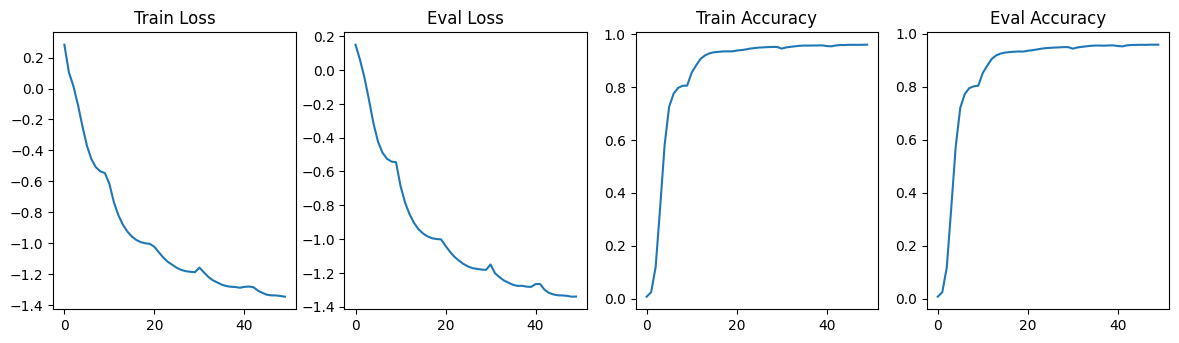

In [379]:
train(model, optimizer, scheduler, EPOCHS, TRAIN_BATCH_SIZE);

eta=0ss
Completed training in 41.75 s. Loaded epoch 49


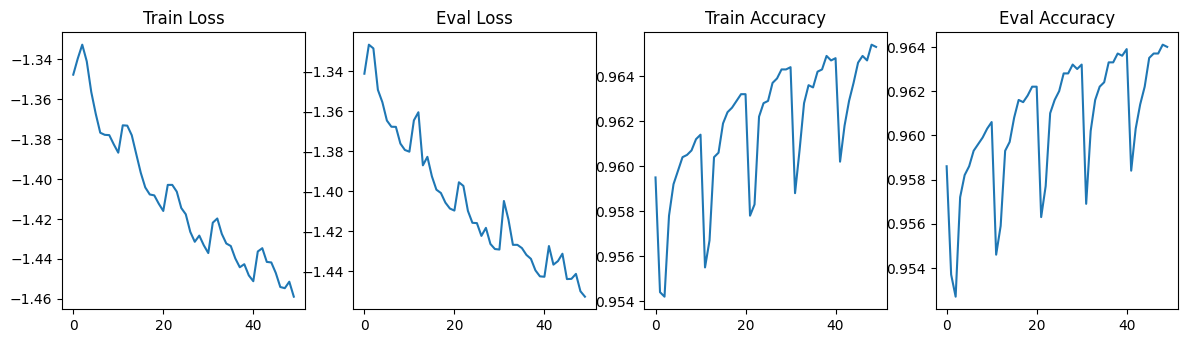

In [380]:
train(model, optimizer, scheduler, EPOCHS, TRAIN_BATCH_SIZE);

# Evaluate model

Accuracy

In [381]:
get_accuracy(model, train_inp, train_out, 0.5, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.5, EVAL_BATCH_SIZE)

(0.9653, 0.9641)

In [382]:
get_accuracy(model, train_inp, train_out, 0.1, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.1, EVAL_BATCH_SIZE)

(0.9652, 0.9641)

In [383]:
get_accuracy(model, train_inp, train_out, 0.03, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.03, EVAL_BATCH_SIZE)

(0.9653, 0.9641)

Training data

In [384]:
test_inp, test_out = sample_batch(train_inp, train_out, n=3)

In [385]:
print_tensor(test_inp)[:, -10:]

tensor([[388., 389., 390., 391., 392., 393., 394., 395., 396.,  -1.],
        [324., 325., 326., 327., 328.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]],
       device='cuda:0')

In [386]:
print_tensor(test_out)[:, -10:]

tensor([[389, 390, 391, 392, 393, 394, 395, 396, 397, 398],
        [325, 326, 327, 328, 329, 330, 331, 332, 333, 334],
        [954, 955, 956, 957, 958, 959, 960, 961, 962, 963]], device='cuda:0')

In [387]:
with torch.no_grad():
    test_pred = model.evaluate(test_inp)
print_tensor(test_pred)[:, -10:]

tensor([[389., 390., 391., 392., 393., 394., 395., 396., 397., 398.],
        [325., 326., 327., 328., 329., 330., 331., 332., 333., 334.],
        [954., 955., 956., 957., 958., 959., 960., 961., 962., 963.]],
       device='cuda:0')

Evaluation data

In [388]:
test_inp, test_out = sample_batch(train_inp, train_out, n=4)

In [389]:
print_tensor(test_inp)[:, -10:];

In [390]:
print_tensor(test_out)[:, -10:]

tensor([[292, 293, 294, 295, 296, 297, 298, 299, 300, 301],
        [857, 858, 859, 860, 861, 862, 863, 864, 865, 866],
        [851, 852, 853, 854, 855, 856, 857, 858, 859, 860],
        [755, 756, 757, 758, 759, 760, 761, 762, 763, 764]], device='cuda:0')

In [391]:
with torch.no_grad():
    test_pred = model.evaluate(test_inp)
print_tensor(test_pred)[:, -10:]

tensor([[292., 293., 294., 295., 296., 297., 398., 399., 300., 301.],
        [857., 858., 859., 860., 861., 862., 863., 864., 865., 866.],
        [851., 852., 853., 854., 855., 856., 857., 858., 859., 860.],
        [755., 756., 757., 758., 759., 760., 761., 762., 763., 764.]],
       device='cuda:0')

In [392]:
with torch.no_grad():
    test_position = model.evaluate(test_inp, single=True)
print_tensor(test_position)

tensor([301., 866., 860., 764.], device='cuda:0')

In [393]:
with torch.no_grad():
    test_position = model.evaluate(test_inp, single=True, pos_idx=-1)
print_tensor(test_position)

tensor([301., 866., 860., 764.], device='cuda:0')

# View attention

In [394]:
def plot_attention(inputs: Tensor, layer_index: int | None = None, size=(1440, 1080), inverse=False,
                   cmap='bone_r', crop=1, exg=1, single=False, force_line=False):
    assert inputs.ndim in [1, 2]
    plt.close()

    # Calculate attention
    with torch.no_grad():
        model.evaluate(inputs, get=True, single=single).cpu()
        tx_base = model.transformer

    # Get layers self attention
    self_attention = [l[0].to('cpu', torch.float64) for l in tx_base.get_attention()]
    # self_attention = [l[0].to('cpu', torch.float64) for l in tx_base.get_attention()]
    if layer_index is not None:
        self_attention = self_attention[[layer_index]]
    # if layer_index is not None:
    #     self_attention = self_attention[layer_index].to('cpu', torch.float64)
    # else:
    #     self_attention = torch.mean(torch.stack(self_attention), dim=0).to('cpu', torch.float64)
    print(self_attention[0].shape)
    b, heads, q, k = self_attention[0].shape
    if b > 1:
        self_attention = [t.mean(dim=0, keepdim=True) for t in self_attention]
    rows = heads
    columns = len(self_attention) if layer_index is None else 1
    # print(rows, columns)
    fig, axes = plt.subplots(rows, columns, figsize=(size[0] * 0.01, size[1] * 0.01))
    # fig.patch.set_facecolor(bg)
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    else:
        if rows == 1:
            axes = np.expand_dims(axes, 0)
        if columns == 1:
            axes = np.expand_dims(axes, 1)
    if inverse:
        axes = axes.transpose()
    # print(axes.shape)
    x = 0
    for li, attention in enumerate(self_attention):
        for hi, att_head in enumerate(attention[0]):
            title = f"L{li if layer_index is None else layer_index} H{hi}"
            if force_line:
                att_head = att_head[[-1]]
            q, k = att_head.shape[-2:]
            # print(q, k)
            if q != 1:
                # att_head = att_head.expand(k, k)
                # q = k
                if exg is not None:
                    att_head = torch.clamp(att_head * exg, 0, 1)
                if crop is not None:
                    k_red = k // crop
                    k_max = max(1, k // 2 - k_red)
                    k_idx = np.random.randint(k_max)
                    k_ind = torch.arange(k_idx, k_idx + k_red).to(att_head.device)
                    q_red = min(q, q // crop)
                    q_max = max(1, q // 2 - q_red)
                    q_idx = np.random.randint(q_max)
                    q_ind = torch.arange(q_idx, q_idx + q_red).to(att_head.device)
                    # print(q_ind, k_ind, att_head.shape)
                    # print(att_head.shape, q_ind.shape, k_ind.shape, q, k)
                    att_head = torch.index_select(torch.index_select(att_head, 0, q_ind), 1, k_ind)
                    # print(att_head.shape)
                axes[x].imshow(att_head.float().cpu(), cmap=cmap)
            else:
                axes[hi, li].plot(att_head.squeeze(0))
            axes[hi, li].set_title(title)
            x += 1
    plt.show()

torch.Size([1, 100]) 6
torch.Size([5, 1, 100, 100])


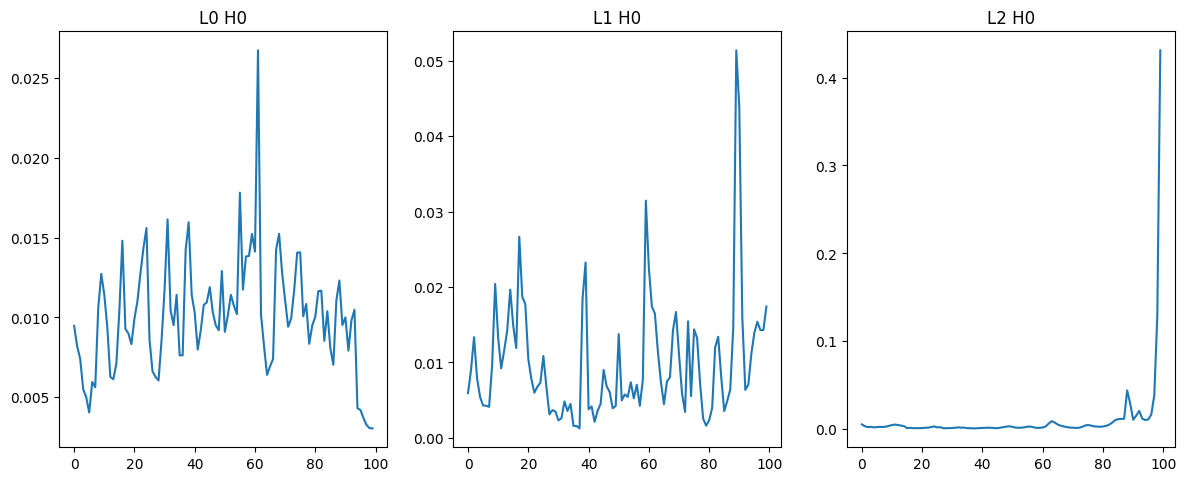

In [395]:
sample_input = sample_batch(eval_inp, n=1)[0]
missing_count = torch.count_nonzero(torch.round(sample_input.to(torch.float) / MULTIPLIER) if not EMBEDDED else sample_input == -1).cpu().item()
print(sample_input.shape, missing_count)
plot_attention(sample_input, layer_index=None, size=(1440, 540), crop=1, exg=3, single=True, force_line=True)

torch.Size([1, 100]) 0
torch.Size([5, 1, 100, 100])


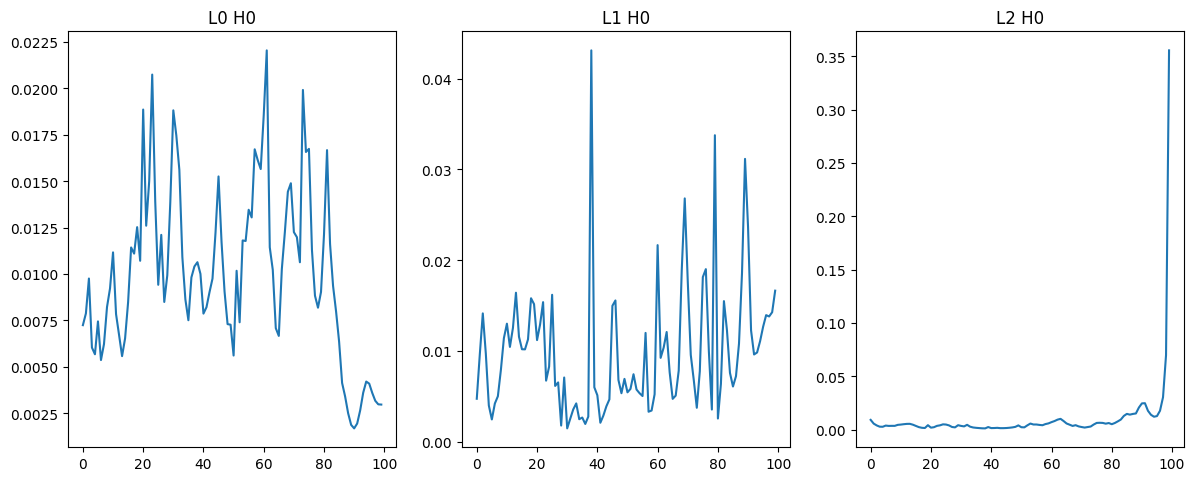

In [396]:
sample_input = sample_batch(eval_inp, n=1)[0]
missing_count = torch.count_nonzero(torch.round(sample_input.to(torch.float) / MULTIPLIER) == -1).cpu().item()
print(sample_input.shape, missing_count)
plot_attention(sample_input, layer_index=None, size=(1440, 540), crop=1, exg=3, single=False, force_line=True)

# View generation

In [397]:
def evaluate(model: Transformer, start_value: int, length: int, seq_len: int | None = None, view=True):
    if seq_len is None:
        seq_len = SEQ_LEN
    if view:
        print(start_value, length)
    last_value = start_value + (seq_len * STEP)
    tensor = torch.arange(
        start_value, last_value, STEP,
        device=model.device, dtype=model.dtype
    )
    result_start = last_value + OFFSET
    expected = torch.arange(result_start, result_start + length, device='cpu', dtype=torch.float64)
    generated = []

    # print(tensor)
    # print(expected)
    for step in range(length):
        with torch.no_grad():
            if not EMBEDDED:
                prediction = torch.round(model(tensor * MULTIPLIER, single=True) / MULTIPLIER, decimals=0)
            else:
                prediction = model.evaluate(tensor, single=True)
        generated.append(prediction)
        # print(expected.shape, prediction.shape, prediction, expected[step])
        tensor[:-1] = tensor[1:].clone()
        tensor[-1] = prediction

    generated = torch.stack(generated, 0).to('cpu', torch.float64)

    if view:
        plt.close()
        plt.plot(expected, label='expected')
        plt.plot(generated, label='generated')
        plt.legend()
        plt.show()

    return generated == expected

163 10


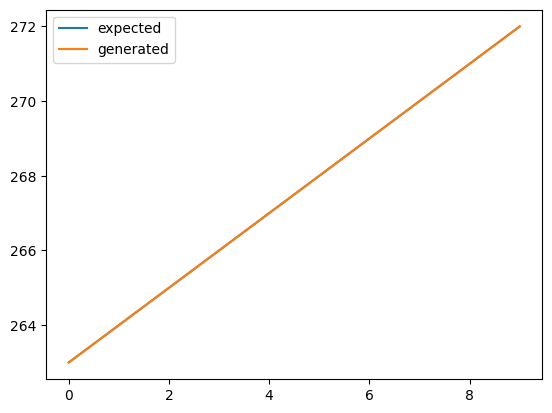

tensor([True, True, True, True, True, True, True, True, True, True])

In [398]:
evaluate(model, start_value=random.randint(100, 1000), length=10, seq_len=None)

In [399]:
evaluation = []
failures = []
ts, ud, ut = clock.perf_counter(), 0, 1000
for i in range(1000):
    ud += 1
    res = torch.all(evaluate(model, start_value=i, length=10, seq_len=None, view=False)).item()
    evaluation.append(res)
    if not res:
        failures.append(i)
    eta(ts, ud, ut)
    # print(f"\reta = {clock.perf_counter() - ts:.2f} s", end='')
print(f"\rFinished in {clock.perf_counter() - ts:.2f} s")

Finished in 50.29 s


In [400]:
len(failures)

180

In [401]:
test_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

In [402]:
torch.tensor(failures)[test_indices]

tensor([  0,  91,  92,  93,  94,  95,  96,  97,  98,  99, 986, 991, 992, 993,
        994, 995, 996, 997, 998, 999])

In [403]:
failures

[0,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 691,
 692,
 693,
 694,
 695,
 696,
 697,
 698,
 699,
 700,
 791,
 792,
 793,
 794,
 795,
 796,
 797,
 798,
 799,
 800,
 891,
 892,
 893,
 894,
 895,
 896,
 897,
 898,
 899,
 900,
 907,
 908,
 909,
 910,
 911,
 912,
 913,
 914,
 915,
 916,
 917,
 918,
 919,
 920,
 921,
 922,
 923,
 924,
 925,
 926,
 927,
 928,
 929,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 937,
 938,
 939,
 940,
 941,
 942,
 943,
 944,
 945,
 946,
 947,
 948,
 949,
 950,
 951,
 952,
 953,
 954,
 955,
 956,
 957,
 958,
 959,
 960,
 961,
 962,
 963,
 964,
 965,
 966,
 967,
 968,
 969,
 970,
 971,
 972,
 973,
 974,
 975,
 976,
 977,
 978,
 979,
 980,
 981,
 982,
 983,
 98

893 10


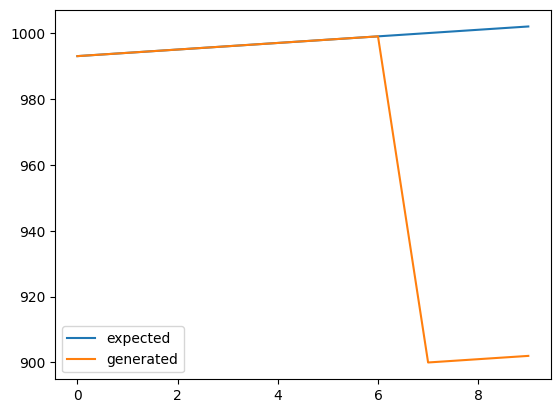

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False])

In [405]:
evaluate(model, start_value=893, length=10, seq_len=None)